In [1]:
import os
import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"]="3" # specify visible gpu(s), can check gpu usage in terminal using 'nvidia-smi'

try:
    tf_gpus = tf.config.list_physical_devices('GPU')
    for gpu in tf_gpus:
        tf.config.experimental.set_memory_growth(gpu, True) # allow memory growth on visible gpu(s)
except:
    pass

In [2]:
import matplotlib.pyplot as plt # for plotting images

from tifffile import tifffile

import numpy as np
import pandas as pd
import glob
from skimage.io import imsave
from skimage import img_as_ubyte
import skimage 
import skimage.io
import skimage.measure
import skimage.morphology
from tqdm import tqdm

from deepcell.applications import Mesmer # Mesmer
from deepcell.utils.plot_utils import create_rgb_image, make_outline_overlay

## Segmentation

In [3]:
# path to the final fusion qptiff
# the qptiff needs to be accessible to the analysis server (darthvader)
# the storage server is mounted to the analysis server at /mnt/nfs/storage/ 
# generally we want to avoid storing experiment data in personal folders i.e. /mnt/nfs/home/jasonyeung/
# but for this purpose the images are not large so fine to put in personal folders

image1 = glob.glob('/mnt/nfs/storage/Fusion_Registered_Report/Slide 1_20 min HIER 1h RT stain_Scan1.qptiff') # glob allows you to pull multiple files using a regular expression, but not necessary here
print(image1)

image2 = glob.glob('/mnt/nfs/storage/Fusion_Registered_Report/Slide 2_20 min HIER on 4C stain_Scan1.qptiff') # glob allows you to pull multiple files using a regular expression, but not necessary here
print(image2)

image3= glob.glob('/mnt/nfs/storage/Fusion_Registered_Report/Slide 3_10 min HIER on 4C stain_Scan1.qptiff') # glob allows you to pull multiple files using a regular expression, but not necessary here
print(image3)

image4= glob.glob('/mnt/nfs/storage/Fusion_Registered_Report/Slide 4_40 min HIER on 4C stain_Scan1.qptiff') # glob allows you to pull multiple files using a regular expression, but not necessary here
print(image4)

['/mnt/nfs/storage/Fusion_Registered_Report/Slide 1_20 min HIER 1h RT stain_Scan1.qptiff']
['/mnt/nfs/storage/Fusion_Registered_Report/Slide 2_20 min HIER on 4C stain_Scan1.qptiff']
['/mnt/nfs/storage/Fusion_Registered_Report/Slide 3_10 min HIER on 4C stain_Scan1.qptiff']
['/mnt/nfs/storage/Fusion_Registered_Report/Slide 4_40 min HIER on 4C stain_Scan1.qptiff']


In [4]:
# open the image and check dimensions
slide1 = tifffile.imread(image1[0])
slide1.shape



(28, 21600, 26880)

In [5]:
slide2 = tifffile.imread(image2[0])
slide2.shape

(28, 16560, 24960)

In [6]:
slide3 = tifffile.imread(image3[0])
slide3.shape

(28, 25200, 33600)

In [7]:
slide4 = tifffile.imread(image4[0])
slide4.shape

(28, 22320, 25920)

Dimensions of the image array are (11, 17280, 24960), meaning it is a 3D stack of 2D image arrays (11 channels of 17280 x 24960 images). 

The order of the channels should match the order when you open the qptiff in QuPath for example (C1 in QuPath = first index here, C2 in QuPath = second index here, etc). But also always good to double check

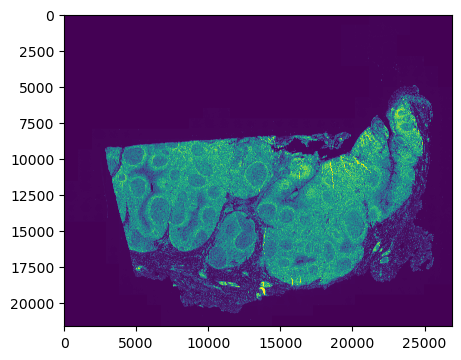

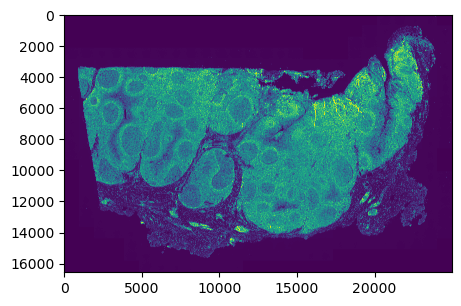

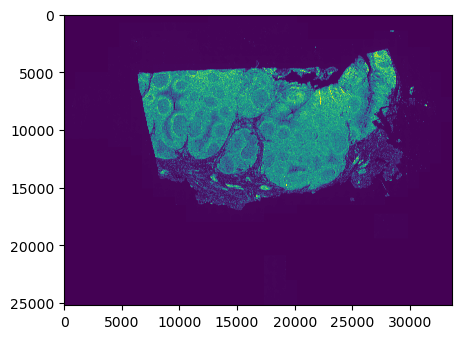

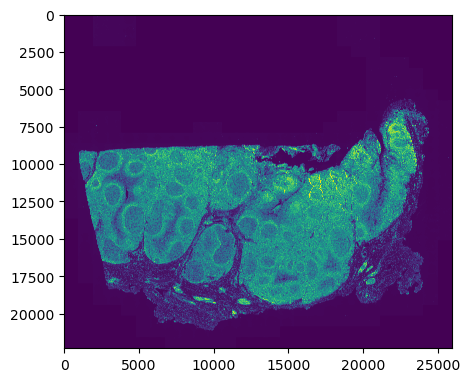

In [8]:
# use this to check which marker is which index in the qptiff
# indexing in python starts at 0 not at 1 like in R, so [0, :, :] = C1 in the qptiff
plt.figure(figsize = (5, 5))
plt.imshow(slide1[0, :, :]);

plt.figure(figsize = (5, 5))
plt.imshow(slide2[0, :, :]);

plt.figure(figsize = (5, 5))
plt.imshow(slide3[0, :, :]);

plt.figure(figsize = (5, 5))
plt.imshow(slide4[0, :, :]);

# 0 = DAPI
# 1 = CD3
# 2 = aSMA
# 3 = CD15
# 4 = CD4
# 5 = CD8
# 6 = CD11b
# 7 = CD11c
# 8 = CD20
# 9 = CCD21
# 10 = CH2K27me3
# 11 = Ki-67
# 12 = HLA-DRA
# 13 = Histone H3
# 14 = CD68
# 15 = DC-SIGN
# 16 = Foxp3
# 17 = PD-1
# 18 = CD163
# 19 = H3K27ac
# 20 = Granzyme B
# 21 = CD31
# 22 = CD206
# 23 = 138
# 24 = NaK ATPase
# 25 = CD45RA
# 26 = CD45
# 27 = Cytokeratin

In [9]:
nuclear1 = np.zeros((21600, 26880))
membrane1 = np.zeros((21600, 26880))

nuclear_markers = [0] # these are indices of the channels we want to use as the nuclear signal (only one here)
membrane_markers = [1, 4, 5, 6, 8, 14, 21, 22, 23, 24, 25, 27] # these are the indices we want to use as the membrane signal (referenced above)

for chn_index in range(len(slide1)):
    arr = slide1[chn_index, :, :] # slice the corresponding index in the first dimension
    if chn_index in nuclear_markers: # if the chn_index is in our list of nuclear markers, stack it to the nuclear array
        nuclear1 = np.add(nuclear1, arr)
    elif chn_index in membrane_markers: # if the chn_index is a membrane_marker, stack it to the membrane array
        membrane1 = np.add(membrane1, arr)
    else:
        pass
    

nuclear2 = np.zeros((16560, 24960))
membrane2 = np.zeros((16560, 24960))

nuclear_markers = [0] # these are indices of the channels we want to use as the nuclear signal (only one here)
membrane_markers = [1, 4, 5, 6, 8, 14, 21, 22, 23, 24, 25, 27] # these are the indices we want to use as the membrane signal (referenced above)

for chn_index in range(len(slide2)):
    arr = slide2[chn_index, :, :] # slice the corresponding index in the first dimension
    if chn_index in nuclear_markers: # if the chn_index is in our list of nuclear markers, stack it to the nuclear array
        nuclear2 = np.add(nuclear2, arr)
    elif chn_index in membrane_markers: # if the chn_index is a membrane_marker, stack it to the membrane array
        membrane2 = np.add(membrane2, arr)
    else:
        pass


    nuclear3 = np.zeros((25200, 33600))
membrane3 = np.zeros((25200, 33600))

nuclear_markers = [0] # these are indices of the channels we want to use as the nuclear signal (only one here)
membrane_markers = [1, 4, 5, 6, 8, 14, 21, 22, 23, 24, 25, 27] # these are the indices we want to use as the membrane signal (referenced above)

for chn_index in range(len(slide3)):
    arr = slide3[chn_index, :, :] # slice the corresponding index in the first dimension
    if chn_index in nuclear_markers: # if the chn_index is in our list of nuclear markers, stack it to the nuclear array
        nuclear3 = np.add(nuclear3, arr)
    elif chn_index in membrane_markers: # if the chn_index is a membrane_marker, stack it to the membrane array
        membrane3 = np.add(membrane3, arr)
    else:
        pass
    

nuclear4 = np.zeros((22320, 25920))
membrane4 = np.zeros((22320, 25920))

nuclear_markers = [0] # these are indices of the channels we want to use as the nuclear signal (only one here)
membrane_markers = [1, 4, 5, 6, 8, 14, 21, 22, 23, 24, 25, 27] # these are the indices we want to use as the membrane signal (referenced above)

for chn_index in range(len(slide4)):
    arr = slide4[chn_index, :, :] # slice the corresponding index in the first dimension
    if chn_index in nuclear_markers: # if the chn_index is in our list of nuclear markers, stack it to the nuclear array
        nuclear4 = np.add(nuclear4, arr)
    elif chn_index in membrane_markers: # if the chn_index is a membrane_marker, stack it to the membrane array
        membrane4 = np.add(membrane4, arr)
    else:
        pass

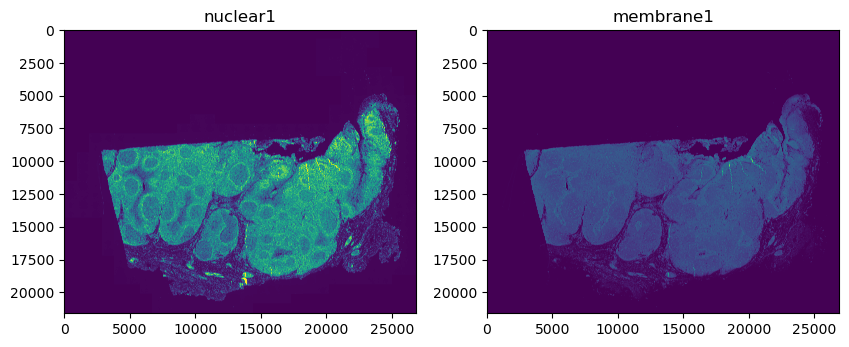

In [10]:
# show the final nuclear and membrane arrays as images
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(nuclear1)
ax[1].imshow(membrane1)

ax[0].set_title('nuclear1')
ax[1].set_title('membrane1');

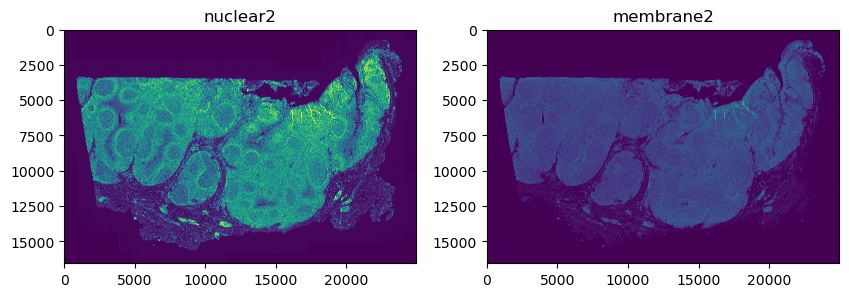

In [11]:
# show the final nuclear and membrane arrays as images
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(nuclear2)
ax[1].imshow(membrane2)

ax[0].set_title('nuclear2')
ax[1].set_title('membrane2');

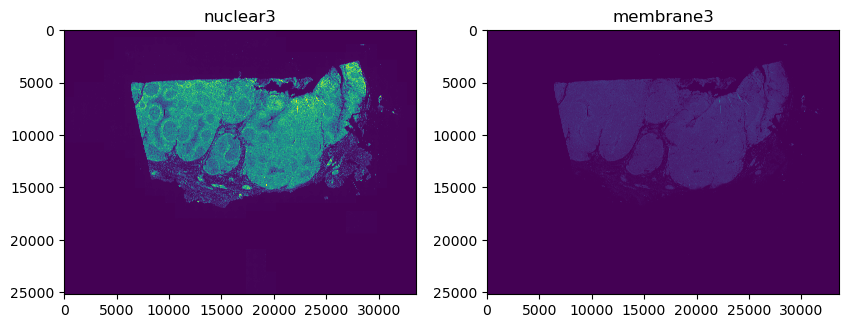

In [12]:
# show the final nuclear and membrane arrays as images
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(nuclear3)
ax[1].imshow(membrane3)

ax[0].set_title('nuclear3')
ax[1].set_title('membrane3');

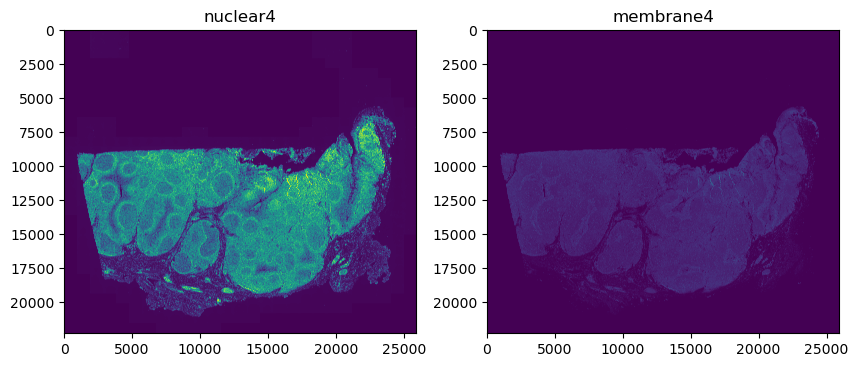

In [13]:
# show the final nuclear and membrane arrays as images
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(nuclear4)
ax[1].imshow(membrane4)

ax[0].set_title('nuclear4')
ax[1].set_title('membrane4');

In [14]:
# save nuclear and membrane tiffs for future reference 
# (can also check that nuclear is actually nuclear by opening the image, hard to tell in a python notebook)
imsave("MESMER_outputs/nuclear1.tiff", nuclear1, check_contrast = False)
imsave("MESMER_outputs/membrane1.tiff", membrane1, check_contrast = False)

In [15]:
# save nuclear and membrane tiffs for future reference 
# (can also check that nuclear is actually nuclear by opening the image, hard to tell in a python notebook)
imsave("MESMER_outputs/nuclear2.tiff", nuclear2, check_contrast = False)
imsave("MESMER_outputs/membrane2.tiff", membrane2, check_contrast = False)

In [16]:
# save nuclear and membrane tiffs for future reference 
# (can also check that nuclear is actually nuclear by opening the image, hard to tell in a python notebook)
imsave("MESMER_outputs/nuclear3.tiff", nuclear3, check_contrast = False)
imsave("MESMER_outputs/membrane3.tiff", membrane3, check_contrast = False)

In [17]:
# save nuclear and membrane tiffs for future reference 
# (can also check that nuclear is actually nuclear by opening the image, hard to tell in a python notebook)
imsave("MESMER_outputs/nuclear4.tiff", nuclear4, check_contrast = False)
imsave("MESMER_outputs/membrane4.tiff", membrane4, check_contrast = False)

In [18]:
# stack the nuclear and membrane arrays we created
stack1 = np.stack((nuclear1, membrane1), axis = -1)

# also expand to 4 dimensions
stack1 = np.expand_dims(stack1, 0)
stack1.shape

(1, 21600, 26880, 2)

In [19]:
# stack the nuclear and membrane arrays we created
stack2 = np.stack((nuclear2, membrane2), axis = -1)

# also expand to 4 dimensions
stack2 = np.expand_dims(stack2, 0)
stack2.shape

(1, 16560, 24960, 2)

In [20]:
# stack the nuclear and membrane arrays we created
stack3 = np.stack((nuclear3, membrane3), axis = -1)

# also expand to 4 dimensions
stack3 = np.expand_dims(stack3, 0)
stack3.shape

(1, 25200, 33600, 2)

In [21]:
# stack the nuclear and membrane arrays we created
stack4 = np.stack((nuclear4, membrane4), axis = -1)

# also expand to 4 dimensions
stack4 = np.expand_dims(stack4, 0)
stack4.shape

(1, 22320, 25920, 2)

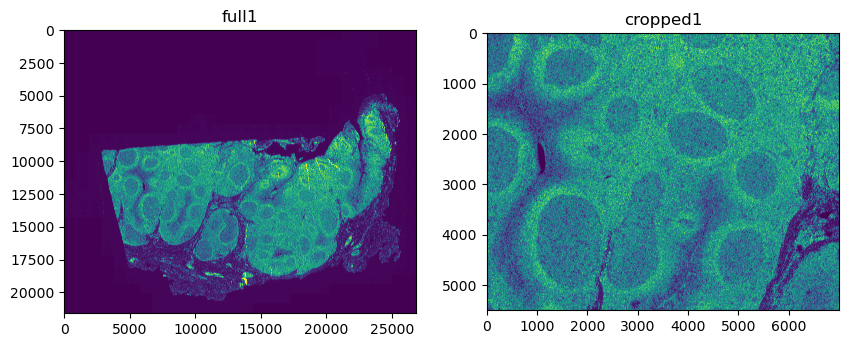

In [22]:
# crop out area of interest
y_min1 = 9500
y_max1 = 15000
x_min1 = 5000
x_max1 = 12000

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(stack1[0, :, :, 0])
ax[1].imshow(stack1[0, y_min1:y_max1, x_min1:x_max1, 0])

ax[0].set_title('full1')
ax[1].set_title('cropped1');

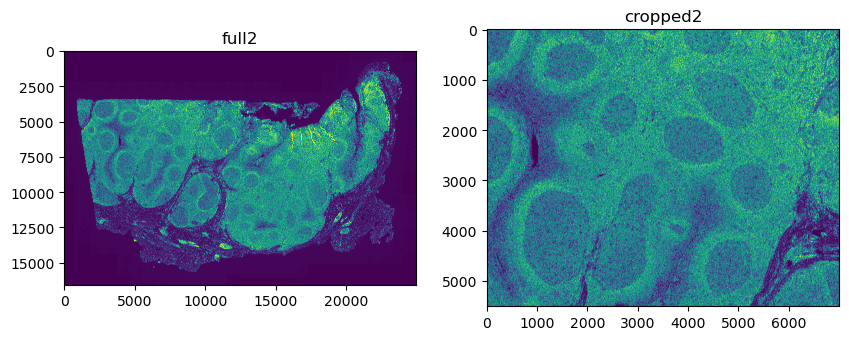

In [23]:
# crop out area of interest
y_min2 = 4000
y_max2 = 9500
x_min2 = 3000
x_max2 = 10000

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(stack2[0, :, :, 0])
ax[1].imshow(stack2[0, y_min2:y_max2, x_min2:x_max2, 0])

ax[0].set_title('full2')
ax[1].set_title('cropped2');

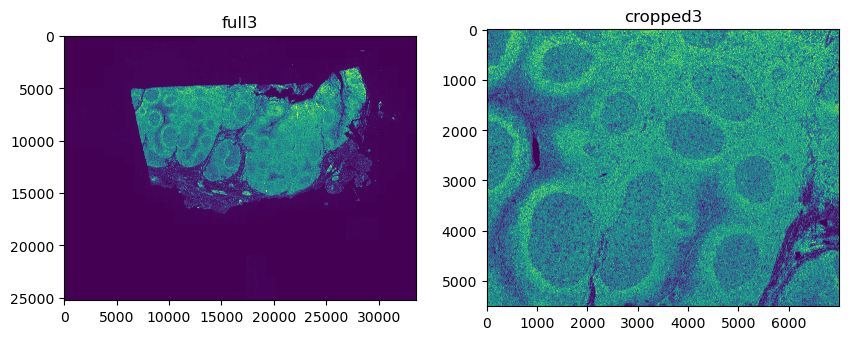

In [24]:
# crop out area of interest
y_min3 = 5500
y_max3 = 11000
x_min3 = 8600
x_max3 = 15600

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(stack3[0, :, :, 0])
ax[1].imshow(stack3[0, y_min3:y_max3, x_min3:x_max3, 0])

ax[0].set_title('full3')
ax[1].set_title('cropped3');

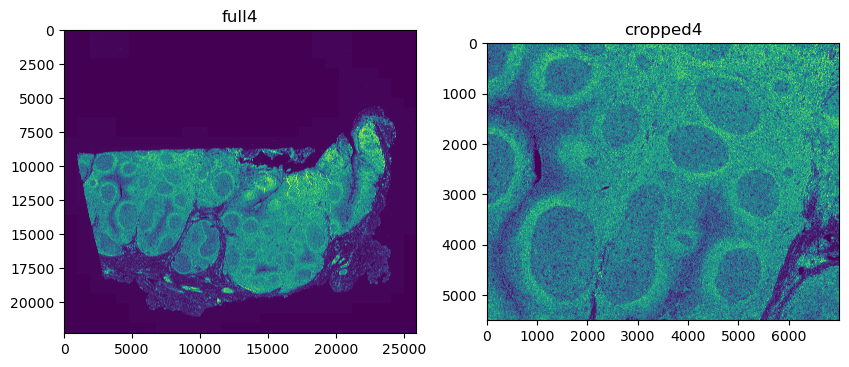

In [25]:
# crop out area of interest
y_min4 = 9600
y_max4 = 15100
x_min4 = 3200
x_max4 = 10200

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(stack4[0, :, :, 0])
ax[1].imshow(stack4[0, y_min4:y_max4, x_min4:x_max4, 0])

ax[0].set_title('full4')
ax[1].set_title('cropped4');

In [26]:
cropped_stack1 = stack1[:, y_min1:y_max1, x_min1:x_max1, :]
cropped_stack1.shape

(1, 5500, 7000, 2)

In [27]:
cropped_stack2 = stack2[:, y_min2:y_max2, x_min2:x_max2, :]
cropped_stack2.shape

(1, 5500, 7000, 2)

In [28]:
cropped_stack3 = stack3[:, y_min3:y_max3, x_min3:x_max3, :]
cropped_stack3.shape

(1, 5500, 7000, 2)

In [29]:
cropped_stack4 = stack4[:, y_min4:y_max4, x_min4:x_max4, :]
cropped_stack4.shape

(1, 5500, 7000, 2)

In [30]:
# these are the Mesmer default parameters for reference:
# default_kwargs_cell = {
#             'maxima_threshold': 0.075,
#             'maxima_smooth': 0,
#             'interior_threshold': 0.2,
#             'interior_smooth': 2,
#             'small_objects_threshold': 15,
#             'fill_holes_threshold': 15,
#             'radius': 2
#         }

# MESMER PARAMETERS
# mpp = microns per pixel resolution, should be static based on experiment
# I believe the phenoimager resolution is advertised as 0.5 mpp at 20x but you guys probably know better than me
image_mpp = 0.50

# maxima_threshold controls what is considered a unique cell (lower values = more separate cells, higher values = fewer cells)
# interior_threshold determines what is considered background/not part of a cell (lower value = larger cells)
maxima_threshold = 0.075
interior_threshold = 0.2

In [31]:
%%time

# run segmentation
app = Mesmer()
predictions1 = app.predict(cropped_stack1, image_mpp = image_mpp,
                          postprocess_kwargs_whole_cell = {"maxima_threshold": maxima_threshold,
                                                           "interior_threshold": interior_threshold})

2024-04-01 10:56:26.564041: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-01 10:56:26.955389: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22341 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:ca:00.0, compute capability: 8.6


2024-04-01 10:56:43.535768: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8500
2024-04-01 10:56:43.906732: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
/opt/miniconda3/envs/cellSeg/lib/python3.9/site-packages/deepcell_toolbox/deep_watershed.py:108: UserWarning: h_maxima peak finding algorithm was selected, but the provided image is larger than 5k x 5k pixels.This will lead to slow prediction performance.
  warnings.warn('h_maxima peak finding algorithm was selected, '
/opt/miniconda3/envs/cellSeg/lib/python3.9/site-packages/deepcell_toolbox/deep_watershed.py:179: FutureWarning: `selem` is a deprecated argument name for `h_maxima`. It will be removed in version 1.0. Please use `footprint` instead.
  markers = h_maxima(image=maxima,


CPU times: user 2min 17s, sys: 11.3 s, total: 2min 28s
Wall time: 2min 29s


In [32]:
%%time

# run segmentation
app = Mesmer()
predictions2 = app.predict(cropped_stack2, image_mpp = image_mpp,
                          postprocess_kwargs_whole_cell = {"maxima_threshold": maxima_threshold,
                                                           "interior_threshold": interior_threshold})

CPU times: user 2min 17s, sys: 11.1 s, total: 2min 29s
Wall time: 2min 29s


In [33]:
%%time

# run segmentation
app = Mesmer()
predictions3 = app.predict(cropped_stack3, image_mpp = image_mpp,
                          postprocess_kwargs_whole_cell = {"maxima_threshold": maxima_threshold,
                                                           "interior_threshold": interior_threshold})

CPU times: user 2min 20s, sys: 10.9 s, total: 2min 31s
Wall time: 2min 32s


In [34]:
%%time

# run segmentation
app = Mesmer()
predictions4 = app.predict(cropped_stack4, image_mpp = image_mpp,
                          postprocess_kwargs_whole_cell = {"maxima_threshold": maxima_threshold,
                                                           "interior_threshold": interior_threshold})

CPU times: user 2min 17s, sys: 10.9 s, total: 2min 28s
Wall time: 2min 29s


In [35]:
rgb_image = create_rgb_image(cropped_stack1, channel_colors = ["green", "blue"])
overlay = make_outline_overlay(rgb_data = rgb_image, predictions = predictions1)

# save MESMER outputs
output_dir = f'/mnt/nfs/home/johannaschaffenrath/RReportexp/MESMER_outputs/{maxima_threshold}maxima_1_{interior_threshold}interior_1/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

skimage.io.imsave(output_dir + "seg_outline1.tiff", img_as_ubyte(overlay[0, ..., 0]), check_contrast = False) # segmentation outline
skimage.io.imsave(output_dir + "seg_overlay1.tiff", img_as_ubyte(overlay[0, ...]), check_contrast = False) # segmentation overlay (nuc + membrane + outline)
skimage.io.imsave(output_dir + "MESMER_mask1.tiff", predictions1[0, ..., 0], check_contrast = False) # MESMER mask

In [36]:
rgb_image = create_rgb_image(cropped_stack2, channel_colors = ["green", "blue"])
overlay = make_outline_overlay(rgb_data = rgb_image, predictions = predictions2)

# save MESMER outputs
output_dir = f'/mnt/nfs/home/johannaschaffenrath/RReportexp/MESMER_outputs/{maxima_threshold}maxima_2_{interior_threshold}interior_2/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

skimage.io.imsave(output_dir + "seg_outline2.tiff", img_as_ubyte(overlay[0, ..., 0]), check_contrast = False) # segmentation outline
skimage.io.imsave(output_dir + "seg_overlay2.tiff", img_as_ubyte(overlay[0, ...]), check_contrast = False) # segmentation overlay (nuc + membrane + outline)
skimage.io.imsave(output_dir + "MESMER_mask2.tiff", predictions2[0, ..., 0], check_contrast = False) # MESMER mask

In [37]:
rgb_image = create_rgb_image(cropped_stack3, channel_colors = ["green", "blue"])
overlay = make_outline_overlay(rgb_data = rgb_image, predictions = predictions3)

# save MESMER outputs
output_dir = f'/mnt/nfs/home/johannaschaffenrath/RReportexp/MESMER_outputs/{maxima_threshold}maxima_3_{interior_threshold}interior_3/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

skimage.io.imsave(output_dir + "seg_outline3.tiff", img_as_ubyte(overlay[0, ..., 0]), check_contrast = False) # segmentation outline
skimage.io.imsave(output_dir + "seg_overlay3.tiff", img_as_ubyte(overlay[0, ...]), check_contrast = False) # segmentation overlay (nuc + membrane + outline)
skimage.io.imsave(output_dir + "MESMER_mask3.tiff", predictions3[0, ..., 0], check_contrast = False) # MESMER mask

In [38]:
rgb_image = create_rgb_image(cropped_stack4, channel_colors = ["green", "blue"])
overlay = make_outline_overlay(rgb_data = rgb_image, predictions = predictions4)

# save MESMER outputs
output_dir = f'/mnt/nfs/home/johannaschaffenrath/RReportexp/MESMER_outputs/{maxima_threshold}maxima_4_{interior_threshold}interior_4/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

skimage.io.imsave(output_dir + "seg_outline4.tiff", img_as_ubyte(overlay[0, ..., 0]), check_contrast = False) # segmentation outline
skimage.io.imsave(output_dir + "seg_overlay4.tiff", img_as_ubyte(overlay[0, ...]), check_contrast = False) # segmentation overlay (nuc + membrane + outline)
skimage.io.imsave(output_dir + "MESMER_mask4.tiff", predictions4[0, ..., 0], check_contrast = False) # MESMER mask

Pause here to validate that segmentation looks good, otherwise tune parameters until satisfied then proceed to feature extraction

## Extract SC features

In [39]:
markers1 = ['DAPI', 'CD3', 'aSMA', 'CD15', 'CD4', 'CD8', 'CD11b', 'CD11c', 'CD20', 'CD21', 'H2K27me3', 'Ki.67', 'HLA.DRA', 'Histone.H3', 'CD68', 'DC.SIGN', 'Foxp3', 'PD.1', 'CD163', 'H3K27ac', 'Granzyme.B', 'CD31', 'CD206', 'CD138', 'NaK.ATPase', 'CD45RA', 'CD45', 'Cytokeratin']

# load in mask
mask1 = skimage.io.imread('/mnt/nfs/home/johannaschaffenrath/RReportexp/MESMER_outputs/0.075maxima_1_0.2interior_1/MESMER_mask1.tiff')

In [40]:
print(f'Image stack shape: {slide1.shape}')

Image stack shape: (28, 21600, 26880)


In [41]:
# transpose the stack dimensions 
array_list = np.transpose(slide1, (1, 2, 0))
array_list.shape

(21600, 26880, 28)

In [42]:
# crop the array to match cropping done earlier
cropped_array_list = array_list[y_min1:y_max1, x_min1:x_max1, :]
cropped_array_list.shape

(5500, 7000, 28)

In [43]:
stats = skimage.measure.regionprops(mask1)
cell_count = len(stats) # number of actual cells not always equal to np.max(mask) 
marker_count = len(markers1)
print(f'Number of cells: {cell_count}')

Number of cells: 176471


In [44]:
# empty containers of zeros
data = np.zeros((cell_count, marker_count))
dataScaleSize = np.zeros((cell_count, marker_count))
cellSizes = np.zeros((cell_count, 1))
cell_props = np.zeros((cell_count, 3))

In [45]:
# extract info
for i in tqdm(range(cell_count)): # tqdm creates the progress bar
    cellLabel = stats[i].label
    label_counts = [cropped_array_list[coord[0], coord[1], :] for coord in stats[i].coords] # all markers for this cell
    data[i, 0:marker_count] = np.sum(label_counts, axis = 0) # sum the marker expression for this cell
    dataScaleSize[i, 0:marker_count] = np.sum(label_counts, axis = 0) / stats[i].area # scale the sum by size
    cellSizes[i] = stats[i].area # cell size
    cell_props[i, 0] = cellLabel
    cell_props[i, 1] = stats[i].centroid[0] # Y centroid
    cell_props[i, 2] = stats[i].centroid[1] # X centroid

100%|██████████| 176471/176471 [00:49<00:00, 3560.15it/s]


In [46]:
data_df = pd.DataFrame(data)
data_df.columns = markers1
data_full = pd.concat((pd.DataFrame(cell_props, columns = ["cellLabel", "Y_cent", "X_cent"]), pd.DataFrame(cellSizes, columns = ["cellSize"]), data_df), axis=1)

dataScaleSize_df = pd.DataFrame(dataScaleSize)
dataScaleSize_df.columns = markers1
dataScaleSize_full = pd.concat((pd.DataFrame(cell_props, columns = ["cellLabel", "Y_cent", "X_cent"]), pd.DataFrame(cellSizes, columns = ["cellSize"]), dataScaleSize_df), axis = 1)
    

In [47]:
data_full.head()

,cellLabel,Y_cent,X_cent,cellSize,DAPI,CD3,aSMA,CD15,CD4,CD8,...,CD163,H3K27ac,Granzyme.B,CD31,CD206,CD138,NaK.ATPase,CD45RA,CD45,Cytokeratin
0,1.0,1.866667,419.644444,45.0,5575.0,31.0,222.0,8.0,1924.0,3.0,...,132.0,397.0,222.0,18.0,18.0,314.0,519.0,2626.0,14.0,3821.0
1,2.0,1.457143,495.028571,35.0,4705.0,155.0,118.0,3.0,1973.0,7.0,...,104.0,288.0,181.0,18.0,14.0,227.0,845.0,1889.0,3.0,2981.0
2,3.0,1.193548,638.193548,31.0,6100.0,50.0,120.0,10.0,1449.0,174.0,...,95.0,238.0,148.0,43.0,20.0,244.0,389.0,1883.0,7.0,2635.0
3,4.0,1.400000,1278.533333,30.0,2249.0,17.0,69.0,0.0,1602.0,3.0,...,54.0,337.0,168.0,340.0,13.0,182.0,585.0,1584.0,1.0,1606.0
4,5.0,1.312500,2471.687500,32.0,4318.0,456.0,108.0,9.0,3054.0,3.0,...,59.0,273.0,191.0,8.0,14.0,201.0,1307.0,1613.0,6.0,2134.0


In [48]:
dataScaleSize_full.head()

,cellLabel,Y_cent,X_cent,cellSize,DAPI,CD3,aSMA,CD15,CD4,CD8,...,CD163,H3K27ac,Granzyme.B,CD31,CD206,CD138,NaK.ATPase,CD45RA,CD45,Cytokeratin
0,1.0,1.866667,419.644444,45.0,123.888889,0.688889,4.933333,0.177778,42.755556,0.066667,...,2.933333,8.822222,4.933333,0.400000,0.400000,6.977778,11.533333,58.355556,0.311111,84.911111
1,2.0,1.457143,495.028571,35.0,134.428571,4.428571,3.371429,0.085714,56.371429,0.200000,...,2.971429,8.228571,5.171429,0.514286,0.400000,6.485714,24.142857,53.971429,0.085714,85.171429
2,3.0,1.193548,638.193548,31.0,196.774194,1.612903,3.870968,0.322581,46.741935,5.612903,...,3.064516,7.677419,4.774194,1.387097,0.645161,7.870968,12.548387,60.741935,0.225806,85.000000
3,4.0,1.400000,1278.533333,30.0,74.966667,0.566667,2.300000,0.000000,53.400000,0.100000,...,1.800000,11.233333,5.600000,11.333333,0.433333,6.066667,19.500000,52.800000,0.033333,53.533333
4,5.0,1.312500,2471.687500,32.0,134.937500,14.250000,3.375000,0.281250,95.437500,0.093750,...,1.843750,8.531250,5.968750,0.250000,0.437500,6.281250,40.843750,50.406250,0.187500,66.687500


In [50]:
# save the dataframes
save_dir = '/mnt/nfs/home/johannaschaffenrath/RReportexp/extracted_features_1234'

if not os.path.exists(save_dir):
    os.mkdir(save_dir)

data_full.to_csv(os.path.join(save_dir, 'data_slide1.csv'), index = False)
dataScaleSize_full.to_csv(os.path.join(save_dir, 'dataScaleSize_slide1.csv'), index = False)

In [51]:
markers2 = ['DAPI', 'CD3', 'aSMA', 'CD15', 'CD4', 'CD8', 'CD11b', 'CD11c', 'CD20', 'CD21', 'H2K27me3', 'Ki.67', 'HLA.DRA', 'Histone.H3', 'CD68', 'DC.SIGN', 'Foxp3', 'PD.1', 'CD163', 'H3K27ac', 'Granzyme.B', 'CD31', 'CD206', 'CD138', 'NaK.ATPase', 'CD45RA', 'CD45', 'Cytokeratin']

# load in mask
mask2 = skimage.io.imread('//mnt/nfs/home/johannaschaffenrath/RReportexp/MESMER_outputs/0.075maxima_2_0.2interior_2/MESMER_mask2.tiff')

In [52]:
print(f'Image stack shape: {slide2.shape}')

Image stack shape: (28, 16560, 24960)


In [53]:
# transpose the stack dimensions 
array_list = np.transpose(slide2, (1, 2, 0))
array_list.shape


(16560, 24960, 28)

In [54]:
# crop the array to match cropping done earlier
cropped_array_list = array_list[y_min2:y_max2, x_min2:x_max2, :]
cropped_array_list.shape

(5500, 7000, 28)

In [55]:
stats = skimage.measure.regionprops(mask2)
cell_count = len(stats) # number of actual cells not always equal to np.max(mask) 
marker_count = len(markers2)
print(f'Number of cells: {cell_count}')

Number of cells: 173118


In [56]:
# empty containers of zeros
data = np.zeros((cell_count, marker_count))
dataScaleSize = np.zeros((cell_count, marker_count))
cellSizes = np.zeros((cell_count, 1))
cell_props = np.zeros((cell_count, 3))

In [57]:
# extract info
for i in tqdm(range(cell_count)): # tqdm creates the progress bar
    cellLabel = stats[i].label
    label_counts = [cropped_array_list[coord[0], coord[1], :] for coord in stats[i].coords] # all markers for this cell
    data[i, 0:marker_count] = np.sum(label_counts, axis = 0) # sum the marker expression for this cell
    dataScaleSize[i, 0:marker_count] = np.sum(label_counts, axis = 0) / stats[i].area # scale the sum by size
    cellSizes[i] = stats[i].area # cell size
    cell_props[i, 0] = cellLabel
    cell_props[i, 1] = stats[i].centroid[0] # Y centroid
    cell_props[i, 2] = stats[i].centroid[1] # X centroid

100%|██████████| 173118/173118 [00:49<00:00, 3528.86it/s]


In [59]:
data_df = pd.DataFrame(data)
data_df.columns = markers2
data_full = pd.concat((pd.DataFrame(cell_props, columns = ["cellLabel", "Y_cent", "X_cent"]), pd.DataFrame(cellSizes, columns = ["cellSize"]), data_df), axis=1)

dataScaleSize_df = pd.DataFrame(dataScaleSize)
dataScaleSize_df.columns = markers2
dataScaleSize_full = pd.concat((pd.DataFrame(cell_props, columns = ["cellLabel", "Y_cent", "X_cent"]), pd.DataFrame(cellSizes, columns = ["cellSize"]), dataScaleSize_df), axis = 1)
    

In [60]:
data_full.head()

,cellLabel,Y_cent,X_cent,cellSize,DAPI,CD3,aSMA,CD15,CD4,CD8,...,CD163,H3K27ac,Granzyme.B,CD31,CD206,CD138,NaK.ATPase,CD45RA,CD45,Cytokeratin
0,1.0,1.744681,2594.085106,47.0,8101.0,722.0,299.0,10.0,3150.0,19.0,...,125.0,1259.0,62.0,21.0,87.0,763.0,1512.0,673.0,4.0,2985.0
1,2.0,0.750000,3122.350000,20.0,3044.0,56.0,134.0,4.0,579.0,3.0,...,38.0,451.0,8.0,4.0,19.0,329.0,582.0,855.0,1.0,1129.0
2,3.0,1.314286,3557.000000,35.0,5679.0,350.0,192.0,10.0,1036.0,214.0,...,117.0,1779.0,40.0,16.0,49.0,508.0,883.0,537.0,5.0,2164.0
3,4.0,0.772727,3716.000000,22.0,3671.0,223.0,114.0,2.0,745.0,54.0,...,58.0,520.0,33.0,12.0,35.0,331.0,597.0,310.0,1.0,1396.0
4,5.0,2.133333,26.733333,60.0,4953.0,51.0,163.0,3.0,658.0,21.0,...,126.0,722.0,14.0,28.0,58.0,525.0,959.0,2090.0,5.0,3424.0


In [61]:
dataScaleSize_full.head()

,cellLabel,Y_cent,X_cent,cellSize,DAPI,CD3,aSMA,CD15,CD4,CD8,...,CD163,H3K27ac,Granzyme.B,CD31,CD206,CD138,NaK.ATPase,CD45RA,CD45,Cytokeratin
0,1.0,1.744681,2594.085106,47.0,172.361702,15.361702,6.361702,0.212766,67.021277,0.404255,...,2.659574,26.787234,1.319149,0.446809,1.851064,16.234043,32.170213,14.319149,0.085106,63.510638
1,2.0,0.750000,3122.350000,20.0,152.200000,2.800000,6.700000,0.200000,28.950000,0.150000,...,1.900000,22.550000,0.400000,0.200000,0.950000,16.450000,29.100000,42.750000,0.050000,56.450000
2,3.0,1.314286,3557.000000,35.0,162.257143,10.000000,5.485714,0.285714,29.600000,6.114286,...,3.342857,50.828571,1.142857,0.457143,1.400000,14.514286,25.228571,15.342857,0.142857,61.828571
3,4.0,0.772727,3716.000000,22.0,166.863636,10.136364,5.181818,0.090909,33.863636,2.454545,...,2.636364,23.636364,1.500000,0.545455,1.590909,15.045455,27.136364,14.090909,0.045455,63.454545
4,5.0,2.133333,26.733333,60.0,82.550000,0.850000,2.716667,0.050000,10.966667,0.350000,...,2.100000,12.033333,0.233333,0.466667,0.966667,8.750000,15.983333,34.833333,0.083333,57.066667


In [62]:
# save the dataframes
save_dir = '/mnt/nfs/home/johannaschaffenrath/RReportexp/extracted_features_1234'

if not os.path.exists(save_dir):
    os.mkdir(save_dir)

data_full.to_csv(os.path.join(save_dir, 'data_slide2.csv'), index = False)
dataScaleSize_full.to_csv(os.path.join(save_dir, 'dataScaleSize_slide2.csv'), index = False)

In [63]:
markers3 = ['DAPI', 'CD3', 'aSMA', 'CD15', 'CD4', 'CD8', 'CD11b', 'CD11c', 'CD20', 'CD21', 'H2K27me3', 'Ki.67', 'HLA.DRA', 'Histone.H3', 'CD68', 'DC.SIGN', 'Foxp3', 'PD.1', 'CD163', 'H3K27ac', 'Granzyme.B', 'CD31', 'CD206', 'CD138', 'NaK.ATPase', 'CD45RA', 'CD45', 'Cytokeratin']

# load in mask
mask3 = skimage.io.imread('//mnt/nfs/home/johannaschaffenrath/RReportexp/MESMER_outputs/0.075maxima_3_0.2interior_3/MESMER_mask3.tiff')

In [64]:
print(f'Image stack shape: {slide3.shape}')

Image stack shape: (28, 25200, 33600)


In [65]:
# transpose the stack dimensions 
array_list = np.transpose(slide3, (1, 2, 0))
array_list.shape


(25200, 33600, 28)

In [66]:
# crop the array to match cropping done earlier
cropped_array_list = array_list[y_min3:y_max3, x_min3:x_max3, :]
cropped_array_list.shape

(5500, 7000, 28)

In [67]:
stats = skimage.measure.regionprops(mask3)
cell_count = len(stats) # number of actual cells not always equal to np.max(mask) 
marker_count = len(markers3)
print(f'Number of cells: {cell_count}')

Number of cells: 179941


In [68]:
# empty containers of zeros
data = np.zeros((cell_count, marker_count))
dataScaleSize = np.zeros((cell_count, marker_count))
cellSizes = np.zeros((cell_count, 1))
cell_props = np.zeros((cell_count, 3))

In [69]:
# extract info
for i in tqdm(range(cell_count)): # tqdm creates the progress bar
    cellLabel = stats[i].label
    label_counts = [cropped_array_list[coord[0], coord[1], :] for coord in stats[i].coords] # all markers for this cell
    data[i, 0:marker_count] = np.sum(label_counts, axis = 0) # sum the marker expression for this cell
    dataScaleSize[i, 0:marker_count] = np.sum(label_counts, axis = 0) / stats[i].area # scale the sum by size
    cellSizes[i] = stats[i].area # cell size
    cell_props[i, 0] = cellLabel
    cell_props[i, 1] = stats[i].centroid[0] # Y centroid
    cell_props[i, 2] = stats[i].centroid[1] # X centroid

100%|██████████| 179941/179941 [00:49<00:00, 3628.85it/s]


In [70]:
data_df = pd.DataFrame(data)
data_df.columns = markers3
data_full = pd.concat((pd.DataFrame(cell_props, columns = ["cellLabel", "Y_cent", "X_cent"]), pd.DataFrame(cellSizes, columns = ["cellSize"]), data_df), axis=1)

dataScaleSize_df = pd.DataFrame(dataScaleSize)
dataScaleSize_df.columns = markers3
dataScaleSize_full = pd.concat((pd.DataFrame(cell_props, columns = ["cellLabel", "Y_cent", "X_cent"]), pd.DataFrame(cellSizes, columns = ["cellSize"]), dataScaleSize_df), axis = 1)
    

In [71]:
data_full.head()

,cellLabel,Y_cent,X_cent,cellSize,DAPI,CD3,aSMA,CD15,CD4,CD8,...,CD163,H3K27ac,Granzyme.B,CD31,CD206,CD138,NaK.ATPase,CD45RA,CD45,Cytokeratin
0,1.0,1.000000,2992.136364,22.0,2626.0,31.0,82.0,8.0,355.0,23.0,...,59.0,241.0,23.0,17.0,43.0,214.0,301.0,1136.0,6.0,1098.0
1,2.0,1.818182,69.151515,66.0,5955.0,20.0,176.0,4.0,382.0,14.0,...,175.0,610.0,22.0,30.0,62.0,699.0,742.0,3272.0,23.0,3051.0
2,3.0,1.244444,721.911111,45.0,5875.0,12.0,157.0,3.0,220.0,6.0,...,149.0,804.0,9.0,36.0,30.0,357.0,445.0,2064.0,11.0,2575.0
3,4.0,1.400000,2445.966667,30.0,5884.0,201.0,160.0,2.0,937.0,29.0,...,136.0,867.0,15.0,9.0,29.0,314.0,599.0,665.0,16.0,2521.0
4,5.0,1.700000,3227.120000,50.0,7253.0,144.0,179.0,14.0,1265.0,7.0,...,132.0,647.0,23.0,12.0,69.0,442.0,1330.0,2068.0,25.0,2842.0


In [72]:
dataScaleSize_full.head()

,cellLabel,Y_cent,X_cent,cellSize,DAPI,CD3,aSMA,CD15,CD4,CD8,...,CD163,H3K27ac,Granzyme.B,CD31,CD206,CD138,NaK.ATPase,CD45RA,CD45,Cytokeratin
0,1.0,1.000000,2992.136364,22.0,119.363636,1.409091,3.727273,0.363636,16.136364,1.045455,...,2.681818,10.954545,1.045455,0.772727,1.954545,9.727273,13.681818,51.636364,0.272727,49.909091
1,2.0,1.818182,69.151515,66.0,90.227273,0.303030,2.666667,0.060606,5.787879,0.212121,...,2.651515,9.242424,0.333333,0.454545,0.939394,10.590909,11.242424,49.575758,0.348485,46.227273
2,3.0,1.244444,721.911111,45.0,130.555556,0.266667,3.488889,0.066667,4.888889,0.133333,...,3.311111,17.866667,0.200000,0.800000,0.666667,7.933333,9.888889,45.866667,0.244444,57.222222
3,4.0,1.400000,2445.966667,30.0,196.133333,6.700000,5.333333,0.066667,31.233333,0.966667,...,4.533333,28.900000,0.500000,0.300000,0.966667,10.466667,19.966667,22.166667,0.533333,84.033333
4,5.0,1.700000,3227.120000,50.0,145.060000,2.880000,3.580000,0.280000,25.300000,0.140000,...,2.640000,12.940000,0.460000,0.240000,1.380000,8.840000,26.600000,41.360000,0.500000,56.840000


In [73]:
# save the dataframes
save_dir = '/mnt/nfs/home/johannaschaffenrath/RReportexp/extracted_features_1234'

if not os.path.exists(save_dir):
    os.mkdir(save_dir)

data_full.to_csv(os.path.join(save_dir, 'data_slide3.csv'), index = False)
dataScaleSize_full.to_csv(os.path.join(save_dir, 'dataScaleSize_slide3.csv'), index = False)

In [74]:
markers4 = ['DAPI', 'CD3', 'aSMA', 'CD15', 'CD4', 'CD8', 'CD11b', 'CD11c', 'CD20', 'CD21', 'H2K27me3', 'Ki.67', 'HLA.DRA', 'Histone.H3', 'CD68', 'DC.SIGN', 'Foxp3', 'PD.1', 'CD163', 'H3K27ac', 'Granzyme.B', 'CD31', 'CD206', 'CD138', 'NaK.ATPase', 'CD45RA', 'CD45', 'Cytokeratin']

# load in mask
mask4 = skimage.io.imread('//mnt/nfs/home/johannaschaffenrath/RReportexp/MESMER_outputs/0.075maxima_4_0.2interior_4/MESMER_mask4.tiff')

In [75]:
print(f'Image stack shape: {slide4.shape}')

Image stack shape: (28, 22320, 25920)


In [76]:
# transpose the stack dimensions 
array_list = np.transpose(slide4, (1, 2, 0))
array_list.shape


(22320, 25920, 28)

In [77]:
# crop the array to match cropping done earlier
cropped_array_list = array_list[y_min4:y_max4, x_min4:x_max4, :]
cropped_array_list.shape

(5500, 7000, 28)

In [78]:
stats = skimage.measure.regionprops(mask4)
cell_count = len(stats) # number of actual cells not always equal to np.max(mask) 
marker_count = len(markers4)
print(f'Number of cells: {cell_count}')

Number of cells: 173676


In [79]:
# empty containers of zeros
data = np.zeros((cell_count, marker_count))
dataScaleSize = np.zeros((cell_count, marker_count))
cellSizes = np.zeros((cell_count, 1))
cell_props = np.zeros((cell_count, 3))

In [80]:
# extract info
for i in tqdm(range(cell_count)): # tqdm creates the progress bar
    cellLabel = stats[i].label
    label_counts = [cropped_array_list[coord[0], coord[1], :] for coord in stats[i].coords] # all markers for this cell
    data[i, 0:marker_count] = np.sum(label_counts, axis = 0) # sum the marker expression for this cell
    dataScaleSize[i, 0:marker_count] = np.sum(label_counts, axis = 0) / stats[i].area # scale the sum by size
    cellSizes[i] = stats[i].area # cell size
    cell_props[i, 0] = cellLabel
    cell_props[i, 1] = stats[i].centroid[0] # Y centroid
    cell_props[i, 2] = stats[i].centroid[1] # X centroid

100%|██████████| 173676/173676 [00:49<00:00, 3488.66it/s]


In [81]:
data_df = pd.DataFrame(data)
data_df.columns = markers4
data_full = pd.concat((pd.DataFrame(cell_props, columns = ["cellLabel", "Y_cent", "X_cent"]), pd.DataFrame(cellSizes, columns = ["cellSize"]), data_df), axis=1)

dataScaleSize_df = pd.DataFrame(dataScaleSize)
dataScaleSize_df.columns = markers4
dataScaleSize_full = pd.concat((pd.DataFrame(cell_props, columns = ["cellLabel", "Y_cent", "X_cent"]), pd.DataFrame(cellSizes, columns = ["cellSize"]), dataScaleSize_df), axis = 1)
    

In [82]:
data_full.head()

,cellLabel,Y_cent,X_cent,cellSize,DAPI,CD3,aSMA,CD15,CD4,CD8,...,CD163,H3K27ac,Granzyme.B,CD31,CD206,CD138,NaK.ATPase,CD45RA,CD45,Cytokeratin
0,1.0,1.410256,419.128205,39.0,3058.0,6.0,93.0,5.0,226.0,2.0,...,110.0,359.0,11.0,2.0,40.0,218.0,769.0,1092.0,2.0,2014.0
1,2.0,1.642857,671.392857,28.0,3603.0,31.0,84.0,2.0,441.0,0.0,...,71.0,273.0,5.0,7.0,27.0,358.0,384.0,1188.0,4.0,1263.0
2,3.0,1.893617,1342.595745,47.0,5169.0,42.0,110.0,5.0,312.0,4.0,...,141.0,527.0,15.0,2.0,36.0,408.0,679.0,1346.0,1.0,2353.0
3,4.0,0.750000,3341.700000,20.0,3511.0,12.0,69.0,3.0,351.0,4.0,...,74.0,261.0,23.0,18.0,28.0,297.0,266.0,514.0,1.0,1052.0
4,5.0,1.000000,3837.833333,36.0,5494.0,469.0,102.0,9.0,1208.0,4.0,...,113.0,624.0,17.0,89.0,34.0,489.0,1018.0,1073.0,2.0,1731.0


In [83]:
dataScaleSize_full.head()

,cellLabel,Y_cent,X_cent,cellSize,DAPI,CD3,aSMA,CD15,CD4,CD8,...,CD163,H3K27ac,Granzyme.B,CD31,CD206,CD138,NaK.ATPase,CD45RA,CD45,Cytokeratin
0,1.0,1.410256,419.128205,39.0,78.410256,0.153846,2.384615,0.128205,5.794872,0.051282,...,2.820513,9.205128,0.282051,0.051282,1.025641,5.589744,19.717949,28.000000,0.051282,51.641026
1,2.0,1.642857,671.392857,28.0,128.678571,1.107143,3.000000,0.071429,15.750000,0.000000,...,2.535714,9.750000,0.178571,0.250000,0.964286,12.785714,13.714286,42.428571,0.142857,45.107143
2,3.0,1.893617,1342.595745,47.0,109.978723,0.893617,2.340426,0.106383,6.638298,0.085106,...,3.000000,11.212766,0.319149,0.042553,0.765957,8.680851,14.446809,28.638298,0.021277,50.063830
3,4.0,0.750000,3341.700000,20.0,175.550000,0.600000,3.450000,0.150000,17.550000,0.200000,...,3.700000,13.050000,1.150000,0.900000,1.400000,14.850000,13.300000,25.700000,0.050000,52.600000
4,5.0,1.000000,3837.833333,36.0,152.611111,13.027778,2.833333,0.250000,33.555556,0.111111,...,3.138889,17.333333,0.472222,2.472222,0.944444,13.583333,28.277778,29.805556,0.055556,48.083333


In [84]:
# save the dataframes
save_dir = '/mnt/nfs/home/johannaschaffenrath/RReportexp/extracted_features_1234'

if not os.path.exists(save_dir):
    os.mkdir(save_dir)

data_full.to_csv(os.path.join(save_dir, 'data_slide4.csv'), index = False)
dataScaleSize_full.to_csv(os.path.join(save_dir, 'dataScaleSize_slide4.csv'), index = False)